In [41]:
# Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pandas_profiling

sns.set_theme()


## 1. Download & Load Data 


In [42]:
DATA_PATH = Path('../data')

if 'data' not in os.listdir('..') or 'train.csv' not in os.listdir('../data'):
    print('downloading kaggle data')
    ! mkdir ../data
    ! kaggle competitions download -c titanic
    ! unzip titanic.zip
    ! mv *.csv ../data
    ! rm titanic.zip
    ! mkdir ../data/submissions
    ! mv ../data/*_submission* ../data/submissions/
else:
    print('kaggle data already downloaded in ../data')
    


kaggle data already downloaded in ../data


In [43]:
train = pd.read_csv(DATA_PATH / 'train.csv', index_col=0)
test = pd.read_csv(DATA_PATH / 'test.csv', index_col=0)

low_func = lambda x: x.lower()

train.columns = map(low_func, train.columns)
test.columns = map(low_func, test.columns)

print('train', train.shape)
print('test', test.shape)

train (891, 11)
test (418, 10)


**variable exploration**

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## 2. Data Analysis & Cleansing

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    418 non-null    int64  
 1   name      418 non-null    object 
 2   sex       418 non-null    object 
 3   age       332 non-null    float64
 4   sibsp     418 non-null    int64  
 5   parch     418 non-null    int64  
 6   ticket    418 non-null    object 
 7   fare      417 non-null    float64
 8   cabin     91 non-null     object 
 9   embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Immediately we see that cabin is a sparse column that has a lot of nulls. 

Age, Embarked & Fare also have null values to deal with

In [46]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot: >

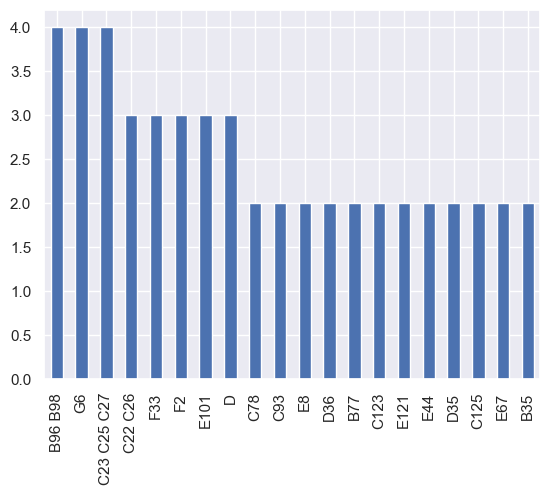

In [47]:
train.cabin.value_counts()[:20].plot.bar()

In [99]:
train.groupby('embarked').survived.mean()

embarked
C    0.553571
Q    0.389610
S    0.339009
Name: survived, dtype: float64

<AxesSubplot: xlabel='embarked', ylabel='Count'>

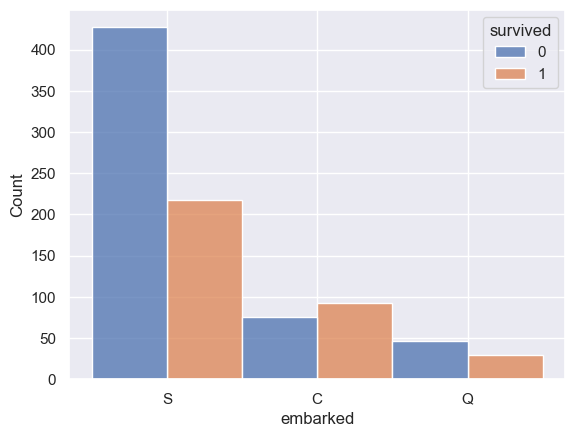

In [48]:
sns.histplot(train, x='embarked', hue='survived', multiple='dodge')

In [49]:
# most people embarked in Southampton so fill na values with an S
train['embarked'] = train.embarked.fillna('S')

# interesting to note that a higher ratio of passengers from C survived

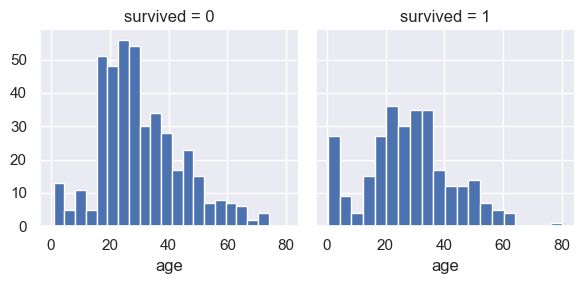

In [50]:
g = sns.FacetGrid(train, col='survived')
g.map(plt.hist, 'age', bins=20)

<AxesSubplot: xlabel='age', ylabel='Count'>

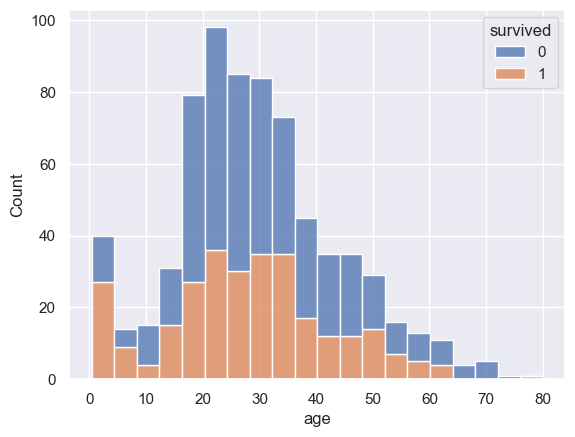

In [51]:
sns.histplot(train, x='age', hue='survived', multiple='stack')

In [97]:
print('Survival rates')
print(f'mean: {train.survived.mean():.2f}')
print(f'u8: {train[train.age < 8].survived.mean():.2f}')

Survival rates
mean: 0.38
u8: 0.68


It appears that children below 8 had a high survival rate, so age will be a strong factor

### Investigate Sex

In [98]:
train.groupby('sex').survived.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

<AxesSubplot: xlabel='age', ylabel='Count'>

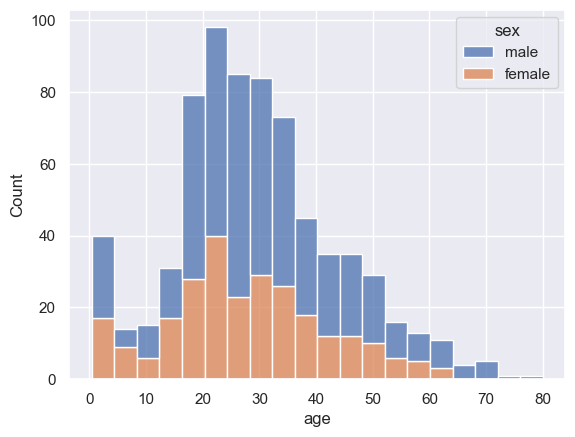

In [86]:
sns.histplot(train, x='age', hue='sex', multiple='stack')

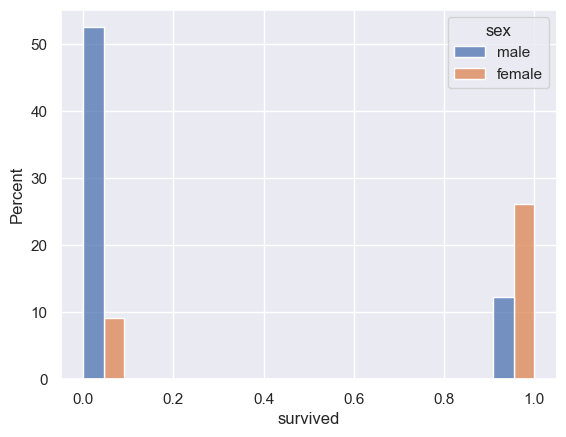

In [88]:
g = sns.histplot(train, x='survived', hue='sex', multiple='dodge', stat='percent')
plt.show()

In [89]:
train.name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: name, Length: 891, dtype: int64

Names are unique (count=891)

### Investigate Passenger Class

<AxesSubplot: xlabel='age', ylabel='Count'>

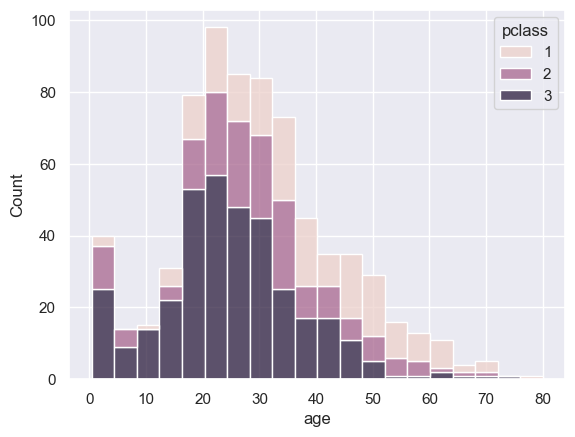

In [100]:
sns.histplot(train, x='age', hue='pclass', multiple='stack')

In [101]:
train.groupby('pclass').age.mean()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64

In [102]:
train.groupby('pclass').survived.mean()

pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

Passengers in first class were on average older

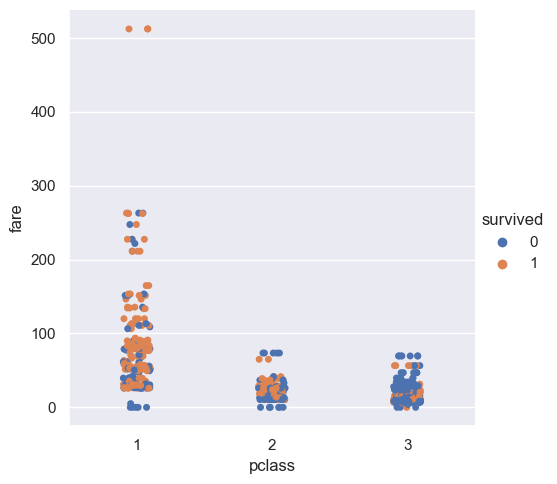

In [103]:
sns.catplot(train, x='pclass', y='fare', hue='survived')

<AxesSubplot: xlabel='age', ylabel='fare'>

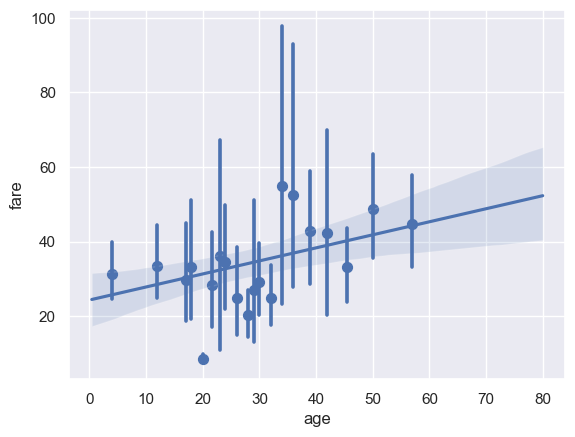

In [104]:
sns.regplot(train, x='age', y='fare', x_bins=20)

<AxesSubplot: xlabel='pclass', ylabel='fare'>

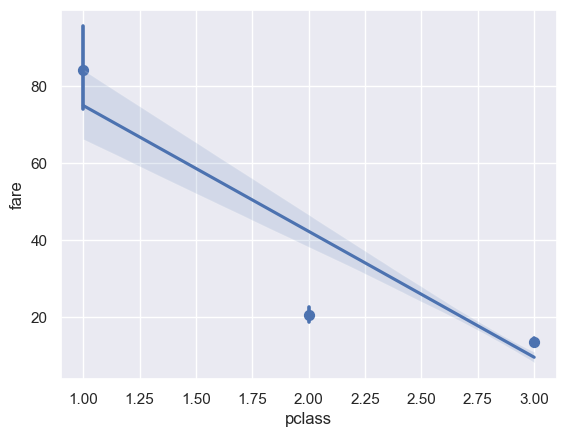

In [105]:
sns.regplot(train, x='pclass', y='fare', x_bins=20)

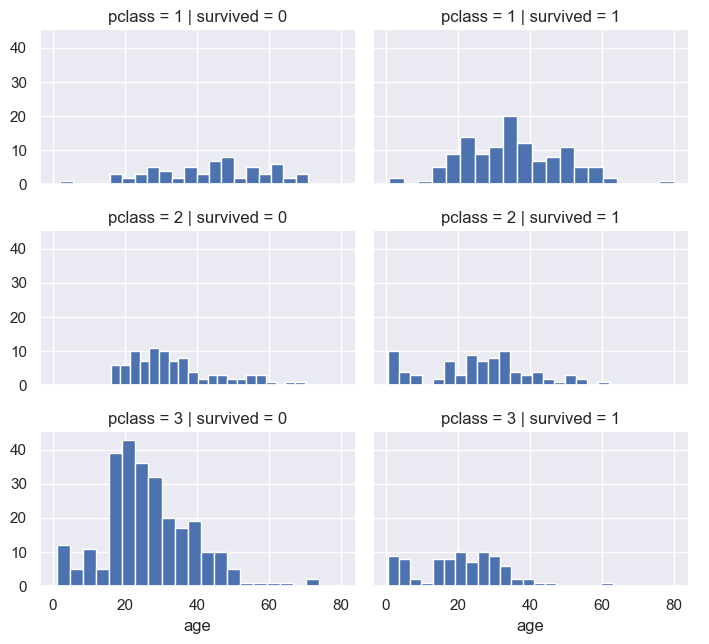

In [106]:
grid = sns.FacetGrid(train, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend();

### Investigate Family Size

In [110]:
train.groupby('sibsp').survived.mean()

sibsp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: survived, dtype: float64

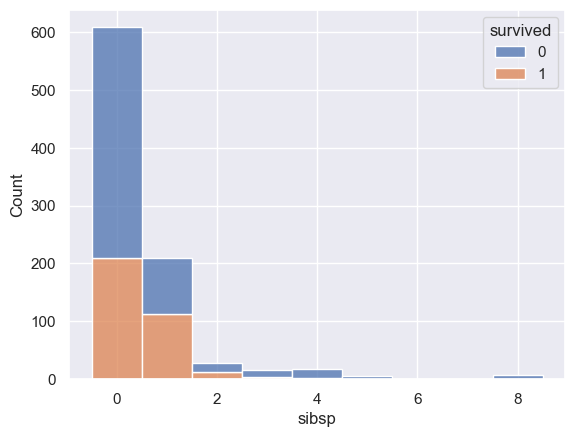

sibsp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: survived, dtype: float64

In [115]:
sns.histplot(train, x='sibsp', hue='survived', multiple='stack', discrete=True)
plt.show()
train.groupby('sibsp').survived.mean()

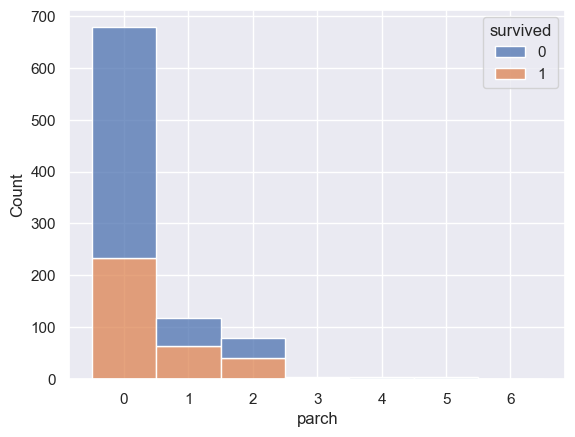

parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: survived, dtype: float64

In [116]:
sns.histplot(train, x='parch', hue='survived', multiple='stack', discrete=True)
plt.show()
train.groupby('parch').survived.mean()

In [119]:
train.groupby(['sex', 'pclass']).age.median()

sex     pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: age, dtype: float64

In [123]:
train.groupby(['sex', 'pclass']).age.transform(lambda x: x.fillna(x.median()))[[6, 18]]

PassengerId
6     25.0
18    30.0
Name: age, dtype: float64

In [120]:
train[pd.isna(train.age)]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


## 3. Feature Engineering

In [ ]:
# target encoding vs one hot

In [ ]:

train['sex'] = train.sex.map({'male': 0, 'female': 1})